# Használjunk nemlineáris transzformációkat

## Végezzünk változótranszformációkat

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def kaliforniai_lakásadatok_betöltése():
    adathalmaz = fetch_california_housing()
    X = pd.DataFrame(data=adathalmaz.data,
                     columns=adathalmaz.feature_names)
    y = pd.Series(data=adathalmaz.target, name="cél")
    print(adathalmaz.DESCR)
    return X, y

X, y = kaliforniai_lakásadatok_betöltése()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [2]:
X["AveOccup"] = X["AveOccup"].clip(upper=100)

X['ÁtlLakóSzoba'] = X['AveOccup'] / X['AveRooms']
X['ÁtlLakóHáló'] = X['AveOccup'] / X['AveBedrms']
X['Szoba_létszám'] = X['Population'] / X['AveRooms']
X['Háló_létszám'] = X['Population'] / X['AveBedrms']
X['Háló_arány'] = X['AveBedrms'] / X['AveRooms']

In [3]:
import numpy as np
from sklearn.feature_selection import f_regression

egy_változó = X["AveOccup"].values.reshape(-1, 1)
F, pérték = f_regression(egy_változó, y)
print(f'Az eredeti jellemző F-pontszáma {F[0]:.1f}')

F, pérték = f_regression(np.log1p(egy_változó),y)
print(f'A transzformált jellemző F-pontszáma {F[0]:.1f}')

Az eredeti jellemző F-pontszáma 275.8
A transzformált jellemző F-pontszáma 1434.7


## Váltsunk ki kölcsönhatásokat változók között

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

regresszió = Pipeline([("normalizáló", StandardScaler()),
                       ("modell",LinearRegression())])
keresztvalidáció = KFold(n_splits=10, shuffle=True,
                        random_state=1)

alapérték = np.mean(cross_val_score(
    regresszió, X, y,
    scoring='neg_mean_squared_error',
    cv=keresztvalidáció))
print(f'Az átlagos négyzetes hiba alapértéke: {abs(alapérték):.3f}')

Az átlagos négyzetes hiba alapértéke: 0.507


In [5]:
from sklearn.preprocessing import PolynomialFeatures

poli = PolynomialFeatures((2, 2), interaction_only=True,
                          include_bias=False)
jellemzők = ["MedInc", "HouseAge", "Population",
            "AveRooms", "AveBedrms", "AveOccup"]
poli.fit(X[jellemzők])
kölcsönhatások = pd.DataFrame(
    poli.transform(X[jellemzők]),
    columns=poli.get_feature_names_out(jellemzők))

In [6]:
print(kölcsönhatások.shape)

(20640, 15)


In [7]:
for oszlop in kölcsönhatások:
    Xt = pd.concat([X, kölcsönhatások[oszlop]], axis=1)
    
    teszt = np.mean(cross_val_score(
        regresszió, Xt, y,
        scoring='neg_mean_squared_error',
        cv=keresztvalidáció))
    if teszt > alapérték:
        print(f"a(z) {oszlop} kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: {abs(teszt):0.3f}")

a(z) MedInc HouseAge kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.504
a(z) MedInc Population kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.500
a(z) MedInc AveRooms kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.501
a(z) MedInc AveBedrms kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.506
a(z) MedInc AveOccup kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.507
a(z) HouseAge Population kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.506
a(z) Population AveOccup kölcsönhatás hozzáadása ennyire javítja az átlagos négyzetes hibát: 0.490


# Regularizáljunk lineáris modelleket

## Támaszkodjunk a Ridge regresszióra (L2)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Xt = pd.concat([X, kölcsönhatások], axis=1)

ridge = Pipeline([("normalizáló", StandardScaler()),
                  ("modell" ,Ridge())])
keresési_rács = {'modell__alpha': np.logspace(-6, 4, 20)}
keresés = GridSearchCV(estimator=ridge,
                      param_grid=keresési_rács,
                      scoring='neg_mean_squared_error',
                      refit=True, cv=keresztvalidáció)
keresés.fit(Xt, y)
print(f'A legjobb paraméterek: {keresés.best_params_}')
pontszám = abs(keresés.best_score_)
print(f'A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: {pontszám:.3f}')

A legjobb paraméterek: {'modell__alpha': 263.6650898730355}
A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: 0.499


## Használjuk a Lassót (L1)

In [9]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

lasso = Pipeline([("normalizáló", StandardScaler()),
                  ("modell",Lasso(selection='random'))])
keresési_rács = {'modell__alpha': np.logspace(-6, 4, 20)}
keresés = GridSearchCV(estimator=lasso,
                      param_grid=keresési_rács,
                      scoring='neg_mean_squared_error',
                      refit=True, cv=keresztvalidáció)
keresés.fit(Xt, y)
legjobb_alfa = keresés.best_params_
print(f'A legjobb paraméterek: {keresés.best_params_}')
pontszám = abs(keresés.best_score_)
print(f'A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: {pontszám:.3f}')

A legjobb paraméterek: {'modell__alpha': 0.004832930238571752}
A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: 0.493


## Alkalmazzuk a regularizációt

In [10]:
kiválasztás = np.abs(
    keresés.best_estimator_["modell"].coef_) > 0
print(Xt.columns[kiválasztás].tolist())

['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'ÁtlLakóSzoba', 'ÁtlLakóHáló', 'Szoba_létszám', 'Háló_létszám', 'Háló_arány', 'MedInc HouseAge', 'MedInc Population', 'MedInc AveRooms', 'HouseAge Population', 'HouseAge AveOccup', 'Population AveRooms', 'Population AveOccup']


## Kombináljuk az L1-et és az L2-t: ElasticNet

In [11]:
from sklearn.linear_model import ElasticNet

rugalmas = Pipeline([
    ("normalizáló", StandardScaler()),
    ("modell", ElasticNet(selection='random'))])
keresési_rács = {'modell__alpha': np.logspace(-6, 4, 20),
          'modell__l1_ratio': [0.05, 0.10 ,0.25, 0.5,
                              0.75, 0.90, 0.95]}
keresés = GridSearchCV(estimator=rugalmas,
                      param_grid=keresési_rács,
                      scoring='neg_mean_squared_error',
                      refit=True, cv=keresztvalidáció)
keresés.fit(Xt, y)
print(f'A legjobb paraméterek: {keresés.best_params_}')
pontszám = abs(keresés.best_score_)
print(f'A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: {pontszám:.3f}')

A legjobb paraméterek: {'modell__alpha': 0.004832930238571752, 'modell__l1_ratio': 0.95}
A legjobb paraméterek keresztvalidációjának átlagos négyzetes hibája: 0.493


# Küzdjünk meg a big data adatokkal darabról darabra

## Valósítsunk meg sztochasztikus gradiens csökkentést

In [12]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

skálázás = MinMaxScaler(feature_range=(0, 1))
skálázott_X = skálázás.fit_transform(Xt)

X_tan, X_t, y_tan, y_t = train_test_split(skálázott_X, y,
                                        test_size=0.20,
                                        random_state=0)
SGD = SGDRegressor(loss='squared_error',
                   penalty='l1',
                   alpha=0.00001,
                   max_iter=2000,
                   learning_rate="adaptive",
                   random_state=0)
SGD.fit(X_tan, y_tan)

pontszám = mean_squared_error(y_t, SGD.predict(X_t))
print(f'A teszthalmaz átlagos négyzetes hibája: {pontszám:.3f}')

A teszthalmaz átlagos négyzetes hibája: 0.494


In [13]:
SGD = SGDRegressor(loss='squared_error',
                   penalty='l1',
                   alpha=0.00001,
                   learning_rate="adaptive",
                   random_state=0)

javulások = list()

for z in range(2000):
    SGD.partial_fit(X_tan, y_tan)
    pontszám = mean_squared_error(y_t, SGD.predict(X_t))
    javulások.append(pontszám)

print(f'A teszthalmaz átlagos négyzetes hibája: {javulások[-1]:.3f}')

A teszthalmaz átlagos négyzetes hibája: 0.472


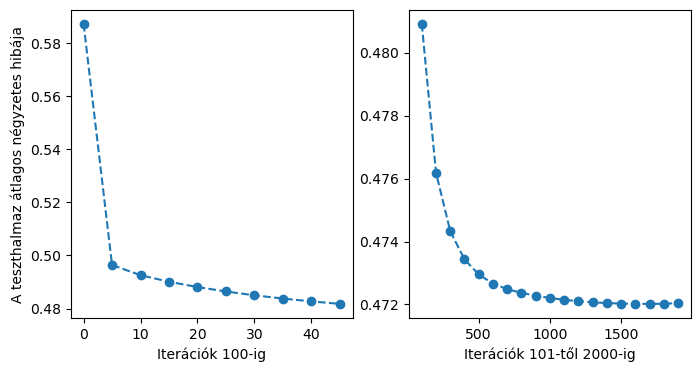

In [14]:
%matplotlib inline
import matplotlib.pyplot as dg

dg.figure(figsize=(8, 4))
dg.subplot(1,2,1)
tartomány_1 = range(0,50,5)
pontszám_1 = np.abs(javulások[0:100:10])
dg.plot(tartomány_1, pontszám_1,'o--')
dg.xlabel('Iterációk 100-ig')
dg.ylabel('A teszthalmaz átlagos négyzetes hibája')
dg.subplot(1,2,2)
tartomány_2 = range(100,2000,100)
pontszám_2 = np.abs(javulások[100:2000:100])
dg.plot(tartomány_2, pontszám_2,'o--')
dg.xlabel('Iterációk 101-től 2000-ig')
dg.show()


# Ismerkedjünk meg a szupport vektor gépekkel

## Osztályozzunk az SVC-vel

In [15]:
from sklearn import datasets
számjegyek = datasets.load_digits()
X, y = számjegyek.data, számjegyek.target

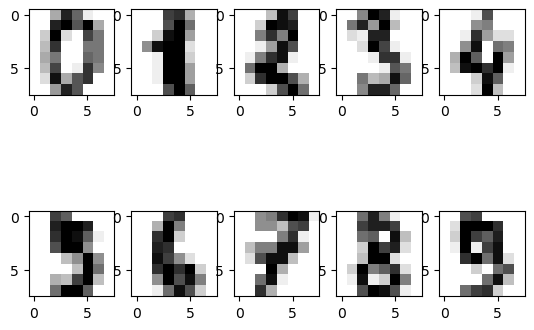

In [16]:
%matplotlib inline

import matplotlib.pyplot as dg
for k, kép in enumerate(range(10)):
    dg.subplot(2, 5, k+1)
    dg.imshow(számjegyek.images[kép],
           cmap='binary',
           interpolation='none')
dg.show()

In [17]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [18]:
print(X[0].reshape(8,8))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [19]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
X_tan, X_t, y_tan, y_t = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [21]:
skálázás = MinMaxScaler(feature_range=(-1, 1)).fit(X_tan)
X_tan = skálázás.transform(X_tan)
X_t = skálázás.transform(X_t)

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', class_weight='balanced')

In [23]:
ke = cross_val_score(svc, X_tan, y_tan, cv=10)
teszt_pontszám = svc.fit(X_tan, y_tan).score(X_t, y_t)

In [24]:
print(f'Keresztvalidáció pontossági pontszáma: {np.mean(ke):.3f}')
print(f'Teszt pontossági pontszáma: {teszt_pontszám:.3f}')

Keresztvalidáció pontossági pontszáma: 0.981
Teszt pontossági pontszáma: 0.976


In [25]:
from sklearn.model_selection import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
keresési_tér = {'C': np.logspace(-3, 3, 7)}
rácskeresés = GridSearchCV(svc,
                          param_grid=keresési_tér,
                          scoring='accuracy',
                          refit=True, cv=10)
rácskeresés.fit(X_tan,y_tan)

GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='accuracy')

In [26]:
ke = rácskeresés.best_score_
teszt_pontszám = rácskeresés.score(X_t, y_t)
legjobb_c = rácskeresés.best_params_['C']

In [27]:
print(f'Keresztvalidáció pontossági pontszáma: {ke:.3f}')
print(f'Teszt pontossági pontszáma: {teszt_pontszám:.3f}')
print(f'A legjobb C paraméter: {legjobb_c:.1f}')

Keresztvalidáció pontossági pontszáma: 0.990
Teszt pontossági pontszáma: 0.993
A legjobb C paraméter: 10.0


## Nemlineárisra váltani egyszerű

In [28]:
from sklearn.model_selection import GridSearchCV

svc = SVC(class_weight='balanced', random_state=1)
keresési_tér = [{'kernel': ['linear'],
                 'C': np.logspace(-3, 3, 7)},
                {'kernel': ['rbf'],
                 'degree':[2, 3, 4],
                 'C':np.logspace(-3, 3, 7),
                 'gamma': np.logspace(-3, 2, 6)}]
rácskeresés = GridSearchCV(svc,
                          param_grid=keresési_tér,
                          scoring='accuracy',
                          refit=True, cv=10,
                          n_jobs=-1)
rácskeresés.fit(X_tan, y_tan)
ke = rácskeresés.best_score_
teszt_pontszám = rácskeresés.score(X_t, y_t)
print(f'Keresztvalidáció pontossági pontszáma: {ke:0.3f}')
print(f'Teszt pontossági pontszáma: {teszt_pontszám:0.3f}')
print(f'A legjobb paraméterek: {rácskeresés.best_params_}')

Keresztvalidáció pontossági pontszáma: 0.990
Teszt pontossági pontszáma: 0.993
A legjobb paraméterek: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Végezzünk regressziót az SVR-rel

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500,
                       n_features=15,
                       n_informative=3,
                       noise=10,
                       random_state=101)

X_tan, X_t, y_tan, y_t = train_test_split(X, y,
                                        test_size=0.3,
                                        random_state=0)
skálázás = MinMaxScaler(feature_range=(-1, 1)).fit(X_tan)
X_tan = skálázás.transform(X_tan)
X_t = skálázás.transform(X_t)

In [30]:
svr = SVR()
keresési_tér = [{'kernel': ['linear'],
                 'C': np.logspace(-3, 2, 6),
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
                {'kernel': ['rbf'],
                 'degree':[2,3],
                 'C':np.logspace(-3, 3, 7),
                 'gamma': np.logspace(-3, 2, 6),
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}]
rácskeresés = GridSearchCV(svr,
                          param_grid=keresési_tér,
                          refit=True,
                          scoring= 'r2',
                          cv=10, n_jobs=-1)
rácskeresés.fit(X_tan, y_tan)
ke = rácskeresés.best_score_
teszt_pontszám = rácskeresés.score(X_t, y_t)
print(f'Keresztvalidáció R2 pontszáma: {ke:.3f}')
print(f'Teszt R2 pontszáma: {teszt_pontszám:.3f}')
print(f'A legjobb paraméterek: {rácskeresés.best_params_}')

Keresztvalidáció R2 pontszáma: 0.990
Teszt R2 pontszáma: 0.992
A legjobb paraméterek: {'C': 100.0, 'epsilon': 0.5, 'kernel': 'linear'}


## Készítsünk sztochasztikus megoldást SVM-mel

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X,y = make_classification(n_samples=500,
                          n_features=15,
                          n_informative=5,
                          random_state=101)
X_tan, X_t, y_tan, y_t = train_test_split(X, y,
                                        test_size=0.3,
                                        random_state=1)

from sklearn.svm import SVC, LinearSVC
svc = SVC(kernel='linear', random_state=0)
lineáris = LinearSVC(loss='hinge', max_iter=100_000,
                   random_state=0)

svc.fit(X_tan, y_tan)
lineáris.fit(X_tan, y_tan)
svc_pontszám = svc.score(X_t, y_t)
libsvc_pontszám = lineáris.score(X_t, y_t)
print(f'Az SVC-teszt pontossága: {svc_pontszám:.3f}')
print(f'A LinearSVC-teszt pontossága: {libsvc_pontszám:.3f}')

Az SVC-teszt pontossága: 0.787
A LinearSVC-teszt pontossága: 0.787


In [32]:
import timeit
import numpy as np

X,y = make_classification(n_samples=10**3,
                          n_features=15,
                          n_informative=5,
                          random_state=101)

t_svc = timeit.timeit(
    'svc.fit(X, y)',
    'from __main__ import svc, X, y',
    number=3)
t_libsvc = timeit.timeit(
    'lineáris.fit(X, y)',
    'from __main__ import lineáris, X, y',
    number=3)
print(f'Az SVC legjobb átlagos ideje: {np.mean(t_svc):0.1f} mp')
print(f'A LinearSVC legjobb átlagos ideje: '
      f'{np.mean(t_libsvc):0.1f}')

Az SVC legjobb átlagos ideje: 0.2 mp
A LinearSVC legjobb átlagos ideje: 0.1


In [33]:
X,y = make_classification(n_samples=3*10**3, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('lineáris.fit(X, y)',
                         'from __main__ import lineáris, X, y', 
                         number=3)
print(f'Az SVC átlagos ideje: {np.mean(t_svc):0.1f} mp')
print(f'A LinearSVC átlagos ideje: {np.mean(t_linear):0.1f} mp')

Az SVC átlagos ideje: 1.7 mp
A LinearSVC átlagos ideje: 0.1 mp


In [34]:
X,y = make_classification(n_samples=5*10**4, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('lineáris.fit(X, y)',
                         'from __main__ import lineáris, X, y', 
                         number=3)
print(f'Az SVC átlagos ideje: {np.mean(t_svc):.1f} mp')
print(f'A LinearSVC átlagos ideje: {np.mean(t_linear):.1f} mp')

Az SVC átlagos ideje: 2282.7 mp
A LinearSVC átlagos ideje: 6.4 mp


In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import timeit

from sklearn.linear_model import SGDClassifier
X, y = make_classification(n_samples=10**5,
                           n_features=15,
                           n_informative=10,
                           random_state=101)
X_tan, X_t, y_tan, y_t = train_test_split(X, y,
                                        test_size=0.3,
                                        random_state=1)

In [36]:
lineáris = LinearSVC(penalty='l2',
                   loss='hinge',
                   dual=True,
                   random_state=101)
lineáris.fit(X_tan, y_tan)
pontszám = lineáris.score(X_t, y_t)
t = timeit.timeit("lineáris.fit(X_tan, y_tan)",
        "from __main__ import lineáris, X_tan, y_tan",
        number=1)
print(f'LinearSVC-teszt pontossága: {pontszám:.3f}')
print(f'A LinearSVC átlagos ideje: {np.mean(t):.1f} mp')

LinearSVC-teszt pontossága: 0.796
A LinearSVC átlagos ideje: 6.1 mp


In [37]:
sgd = SGDClassifier(loss='hinge',
                    penalty='l2',
                    alpha=0.1,
                    max_iter=1000,
                    shuffle=True,
                    random_state=101)
sgd.fit(X_tan, y_tan)
pontszám = sgd.score(X_t, y_t)
t = timeit.timeit("sgd.fit(X_tan, y_tan)",
                  "from __main__ import sgd, X_tan, y_tan",
                  number=1)
print(f'SGDClassifier-teszt pontossága: {pontszám:.3f}')
print(f'Az SGDClassifier átlagos ideje: {np.mean(t):.1f} mp')

SGDClassifier-teszt pontossága: 0.796
Az SGDClassifier átlagos ideje: 0.1 mp


# Játsszunk neurális hálózatokkal

In [38]:
!pip install tensorflow

In [39]:
import tensorflow as tf
print(tf.__version__)


2.15.1


In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
X_tanító, X_teszt, y_tanító, y_teszt = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
skálázó = MinMaxScaler(feature_range=(-1, 1))
X_tanító = skálázó.fit_transform(X_tanító)
X_teszt = skálázó.transform(X_teszt)

In [42]:
osztályok_száma = 10
y_tanító = np.eye(osztályok_száma)[y_tanító]
y_teszt = np.eye(osztályok_száma)[y_teszt]

In [43]:
modell = Sequential()
modell.add(Dense(64, activation='relu', input_shape=(64,)))
modell.add(Dropout(0.2))
modell.add(Dense(32, activation='relu'))
modell.add(Dropout(0.2))
modell.add(Dense(osztályok_száma, activation='softmax'))

modell.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
előzmények = modell.fit(X_tanító, y_tanító, epochs=50,
                    batch_size=32,
                    validation_data=(X_teszt, y_teszt))



Epoch 1/50


45/45 [==============================] - 1s 10ms/step - loss: 2.0446 - accuracy: 0.3097 - val_loss: 1.6023 - val_accuracy: 0.6861
Epoch 2/50
45/45 [==============================] - 0s 5ms/step - loss: 1.3409 - accuracy: 0.6263 - val_loss: 0.9104 - val_accuracy: 0.8111
Epoch 3/50
45/45 [==============================] - 0s 5ms/step - loss: 0.9135 - accuracy: 0.7328 - val_loss: 0.5729 - val_accuracy: 0.8694
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.6656 - accuracy: 0.7961 - val_loss: 0.3950 - val_accuracy: 0.9194
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.5351 - accuracy: 0.8434 - val_loss: 0.3020 - val_accuracy: 0.9389
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.4365 - accuracy: 0.8706 - val_loss: 0.2547 - val_accuracy: 0.9444
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.3630 - accuracy: 0.8935 - val_loss: 0.2051 - val_accuracy: 0.9528
Epoch 8/50
45/4

In [44]:
veszteség, pontosság = modell.evaluate(X_teszt, y_teszt)
print('Teszt pontossági pontszáma:', pontosság)

12/12 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9778
Teszt pontossági pontszáma: 0.9777777791023254


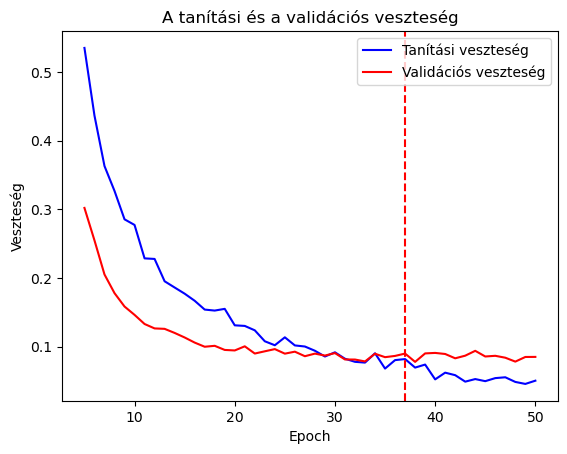

In [45]:
import matplotlib.pyplot as dg

tanítási_veszteség = előzmények.history['loss']
val_veszteség = előzmények.history['val_loss']

# A tanítási és a validációs veszteség ábrázolása az egyes epoch-okban
epoch = range(5, len(tanítási_veszteség) + 1)
dg.plot(epoch, tanítási_veszteség[4:], 'b',
         label='Tanítási veszteség')
dg.plot(epoch, val_veszteség[4:], 'r',
         label='Validációs veszteség')
dg.axvline(x=val_veszteség.index(min(val_veszteség)),
            color='r', linestyle='--')
dg.title('A tanítási és a validációs veszteség')
dg.xlabel('Epoch')
dg.ylabel('Veszteség')
dg.legend()
dg.show()